# Transformer 模型

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.test.is_gpu_available())

TensorFlow 2.x selected.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.1.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.17.5
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

步骤：
1. loads data
2. preprocessess data -> dataset
3. tools
   - generates position embedding
   - create mask (a. padding, b. decoder)
   - scaled_dot_product_attention
4. build model
   - MultiheadAttention
   - EncoderLayer
   - DecoderLayer
   - EncoderModel
   - DecoderModel
   - Transformer
5. train
   - initializes model
   - define loss, optimizer, learning_rate schedule
   - train_step
   - train process
6. train step -> train process
7. Evaluate and Visualize

## 数据处理
### 加载数据

In [6]:
import tensorflow_datasets as tfds

examples, info = tfds.load('ted_hrlr_translate/pt_to_en',
                           with_info = True, as_supervised = True)
train_examples, val_examples = examples['train'], examples['validation']

print(info)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete6QGB3C/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete6QGB3C/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete6QGB3C/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translati

In [7]:
# 输出test
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()

b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'

b'mas e se estes fatores fossem ativos ?'
b'but what if it were active ?'

b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'
b"but they did n't test for curiosity ."

b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'
b'and this conscious defiance is why i , as an agnostic , can still have faith .'

b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''"
b'you can use everything on the table on me .'



In [ ]:
# 从语料中构建subwords-level
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size = 2 ** 13) # 2192
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size = 2 ** 13)

In [9]:
# test 
sample_string = 'Transformer is awesome.'

tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print('The original string is {}'.format(origin_string))

assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> "{}"'.format(token, en_tokenizer.decode([token])))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is Transformer is awesome.
7915 --> "T"
1248 --> "ran"
7946 --> "s"
7194 --> "former "
13 --> "is "
2799 --> "awesome"
7877 --> "."


### 构建Dataset

In [ ]:
buffer_size = 20000
batch_size = 64
max_length = 40

# 把句子转为subword形式
def encode_to_subword(pt_sentence, en_sentence):
    pt_sentence = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(
        pt_sentence.numpy()) + [pt_tokenizer.vocab_size + 1]
    en_sentence = [en_tokenizer.vocab_size] + en_tokenizer.encode(
        en_sentence.numpy()) + [en_tokenizer.vocab_size + 1]
    return pt_sentence, en_sentence

# 过滤大于max_length的句子
def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length, tf.size(en) <= max_length)

# 使用tf.py_function封装py函数
def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword, [pt_sentence, en_sentence], [tf.int64, tf.int64])

In [ ]:
train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(batch_size, padded_shapes=([-1], [-1]))

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(batch_size, padded_shapes=([-1], [-1]))

In [16]:
# test
for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 38) (64, 40)
(64, 39) (64, 35)
(64, 39) (64, 39)
(64, 39) (64, 39)
(64, 39) (64, 36)


## 工具函数
### 位置编码
根据公式写函数

In [ ]:
# 求角度
# pos.shape: [setence_length, 1]
# i.shape: [1, d_model]
# result.shape: [setence_length, d_model]
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

# 求编码
def get_position_embedding(setence_length, d_model):
    angle_rads = get_angles(np.arange(setence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :], d_model)

    # angle_rads.shape: [setence_length, d_model / 2]
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    # position_embedding.shape: [setence_length, d_model]
    # position_embedding = np.concatenate([sines, cosines], axis = -1)
    # position_embedding.shape: [1, setence_length, d_model]
    position_embedding = angle_rads[np.newaxis, ...]
    return tf.cast(position_embedding, dtype=tf.float32)

In [65]:
# test
position_embedding = get_position_embedding(50, 512)
print(position_embedding.shape)

(1, 50, 512)


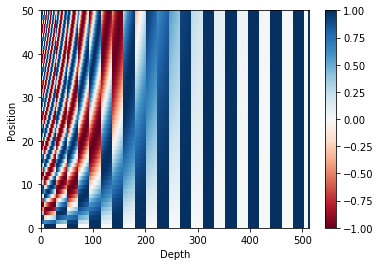

In [66]:
# 画出位置编码的图
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()
    
plot_position_embedding(position_embedding)

### mask构建
1. padding mask
2. look ahead

In [ ]:
# 1. padding mask
# batch_data.shape: [batch_size, seq_len]
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, seq_len]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

In [21]:
# test
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
# 2. look ahead只能看到前面的，看不到后面的
# attention_weights.shape: [3, 3]
# [[1,0,0]
#  [4,5,0]
#  [7,8,9]]
# 下三角都是0，上三角都是1
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    # shape: [seq_len, seq_len]
    return mask

In [23]:
# test 
create_look_ahead_mask(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### 缩放点积注意力机制

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v
    - mask: shape == (..., seq_len_q, seq_len_k) 默认为None
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    
    # matmul_qk.hape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        # 目的是使得在softmax后，值趋近于0
        scaled_attention_logits += (mask * -1e9)
    
    # attention_weights.shape: [..., seq_len_q, seq_len_k]
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    
    # 加权求和
    # output.hape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [ ]:
# 打印缩放点积，方便调试
def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_att)
    print('Output is:')
    print(temp_out)

In [26]:
# 小数四舍五入
np.set_printoptions(suppress=True)
# test
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [27]:
temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [28]:
temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [29]:
temp_q4 = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 模型构建
### 多头注意力

In [ ]:
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上：
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    实际上：把x分成q,k,v
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0
    实战中的技巧：
    q -> Wq -> Q -> split -> q0,q1,q2...
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        
        self.dense = keras.layers.Dense(self.d_model)
        
    def split_heads(self, x, batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # x -> (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.WQ(q) # q.shape: (batch_size, seq_len_q, d_model)
        k = self.WK(k) # k.shape: (batch_size, seq_len_k, d_model)
        v = self.WV(v) # v.shape: (batch_size, seq_len_v, d_model)
        
        q = self.split_heads(q, batch_size) # q.shape: (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # k.shape: (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # v.shape: (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention_outputs.shape: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(scaled_attention_outputs, perm=[0, 2, 1, 3])
        
        # concat_attention.shape: (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs, (batch_size, -1, self.d_model))
        
        # output.shape: (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        return output, attention_weights

In [31]:
# test
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, seq_len_q, d_model)
out, attn = temp_mha(y, y, y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

### feed_forward

In [ ]:
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])

In [33]:
# test
sample_ffn = feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### Encoder Layer

In [ ]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> feed_forward -> add & normalize & dropout
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, seq_len, dim=d_model)
        # attn_output.shape: (batch_size, seq_len, d_model)
        # out1.shape: (batch_size, seq_len, d_model)
        attn_output, _ = self.mha(x, x, x, encoder_padding_mask) 
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(x + attn_output)
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        # out2.shape: (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)
        return out2

In [35]:
# test
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)

sample_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 50, 512])

### Decoder Layer

In [ ]:
class DecoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> out1
    out1, encoding_outputs -> attention -> add & normalize & dropout -> out2
    out2 -> feed_forward -> add & normalize & dropout -> out3
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def call(self, x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask是由look_ahead_mask和decoder_padding_mask做与操作合并而来
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        # attn1,out1.shape: (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask) 
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layer_norm1(x + attn1)
        
        # attn2,out2.shape: (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs, encoder_decoder_padding_mask) 
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layer_norm2(out1 + attn2)
        
        # ffn_output, out3.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training = training)
        out3 = self.layer_norm3(out2 + ffn_output)
        return out3, attn_weights1, attn_weights2

In [37]:
# test 
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_aw1, sample_decoder_aw2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)

print(sample_decoder_output.shape)
print(sample_decoder_aw1.shape)
print(sample_decoder_aw2.shape)

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


### Encoder Model

In [ ]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate = 0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        
        self.embedding = keras.layers.Embedding(input_vocab_size, self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(self.max_length, self.d_model)
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            message='input_seq_len should be less or equal to self.max_length')
        
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        # 做缩放，范围是0-d_model，目的是在与position_embedding做完加法后，x起的作用更大
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :input_seq_len, :]
        x = self.dropout(x, training = training)
        
        # x.shape: (batch_size, input_seq_len, d_model)
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training, encoder_padding_mask)
            
        return x

In [39]:
# test
sample_encoder_model = EncoderModel(2, 8500, max_length, 512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(
    sample_encoder_model_input, training=False, encoder_padding_mask=None)

print(sample_encoder_model_output.shape)

(64, 37, 512)


### Decoder Model

In [ ]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate = 0.1):
        super(DecoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        
        self.embedding = keras.layers.Embedding(target_vocab_size, self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(self.max_length, self.d_model)
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
    def call(self, x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            output_seq_len, self.max_length,
            message='output_seq_len should be less or equal to self.max_length')
        
        attention_weights = {}
        
        # x.shape: (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        # 做缩放，范围是0-d_model，目的是在与position_embedding做完加法后，x起的作用更大
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :output_seq_len, :]
        x = self.dropout(x, training = training)
        
        # x.shape: (batch_size, output_seq_len, d_model)
        for i in range(self.num_layers):
            x, att1, att2 = self.decoder_layers[i](
                x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)
            attention_weights['decoder_layer{}_att1'.format(i+1)] = att1
            attention_weights['decoder_layer{}_att2'.format(i+1)] = att2
        
        return x, attention_weights

In [41]:
# test
sample_decoder_model = DecoderModel(2, 8000, max_length, 512, 8, 2048)
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_att = sample_decoder_model(
    sample_decoder_model_input, sample_encoder_model_output,
    training = False, decoder_mask = None, encoder_decoder_padding_mask = None)

print(sample_decoder_model_output.shape)
for key in sample_decoder_model_att:
    print(sample_decoder_model_att[key].shape)

(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


### Transformer

In [ ]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate = 0.1):
        super(Transformer, self).__init__()
        self.encoder_model = EncoderModel(num_layers, input_vocab_size, max_length,
                                          d_model, num_heads, dff, rate)
        self.decoder_model = DecoderModel(num_layers, target_vocab_size, max_length,
                                          d_model, num_heads, dff, rate)
        self.final_layer = keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(inp, training, encoder_padding_mask)
        
        # decoding_outputs.shape: (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            tar, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)
        
        # decoding_outputs.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights

In [43]:
# test
sample_transformer = Transformer(2, 8500, 8000, max_length, 512, 8, 2048, rate=0.1)

temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

predictions, attention_weights = sample_transformer(
    temp_input, temp_target, training = False, encoder_padding_mask = None,
    decoder_mask = None, encoder_decoder_padding_mask = None)

print(predictions.shape)
for key in attention_weights:
    print(key, attention_weights[key].shape)

(64, 31, 8000)
decoder_layer1_att1 (64, 8, 31, 31)
decoder_layer1_att2 (64, 8, 31, 26)
decoder_layer2_att1 (64, 8, 31, 31)
decoder_layer2_att2 (64, 8, 31, 26)


## Train
### initializes model

In [ ]:
# 定义超参数
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

In [ ]:
# model
transformer = Transformer(num_layers, input_vocab_size, target_vocab_size,
                          max_length, d_model, num_heads, dff, dropout_rate)

### 自定义学习率
learning_rate 先增后减

$$
lrate = (d\_model^{-0.5}) * min(step\_num^{-0.5}, step\_num * warm\_up\_steps^{-1.5})
$$ 

In [ ]:
class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomizedSchedule, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        arg3 = tf.math.rsqrt(tf.cast(self.d_model, dtype=tf.float32))
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train step')

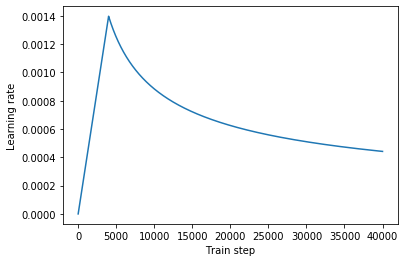

In [47]:
# 画出learning_rate变化图示
temp_learning_rate = CustomizedSchedule(d_model)

plt.plot(temp_learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning rate')
plt.xlabel('Train step')

### Loss

In [ ]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # 去除padding，去噪声
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

### 工具函数：mask创建
问题：一个多头注意力，只能有一个mask，但是DecoderLayer上有两个mask，即look_ahead_mask,decoder_padding_mask，该怎么办？

答：将两个mask做与操作，只要其中一个有mask，就mask

In [ ]:
def create_masks(inp, tar):
    """
    Encoder:
      - encoder_padding_mask (self attention of EncoderLayer)
    Decoder:
      - look_ahead_mask (self attention of DecoderLayer)
      - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
      - decoder_padding_mask (self attention of DecoderLayer)
    """
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = create_padding_mask(tar)
    decoder_mask = tf.maximum(decoder_padding_mask, look_ahead_mask)
    
#     print(encoder_padding_mask.shape)
#     print(encoder_decoder_padding_mask.shape)
#     print(look_ahead_mask.shape)
#     print(decoder_padding_mask.shape)
#     print(decoder_mask.shape)
    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [50]:
# test 
temp_inp, temp_tar = iter(train_dataset.take(1)).next()

print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp, temp_tar)

(64, 38)
(64, 37)


(<tf.Tensor: shape=(64, 1, 1, 38), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1, 37, 37), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.

### 模型保存

In [ ]:
checkpoint_path = os.path.join('/content/drive/My Drive/Colab Notebooks/transformer')
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)
    print(checkpoint_path)
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# 如果检查点存在，则恢复最新的检查点
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

### 训练Train step

In [ ]:
# 方便可视训练过程，不是真正的NMT的训练准确度
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

@tf.function(experimental_relax_shapes=True)
def train_step(inp, tar):
    # 把目标数据切分成decoder input和decoder output
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    # 获取mask
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask = create_masks(inp, tar_inp)
    
    # 计算梯度
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, encoder_padding_mask,
                                     decoder_mask, encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # 累积loss 和 accuracy
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [53]:
# 训练：遍历数据集
epochs = 20
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # 训练
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
    # 保存
    if(epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
    
    # 打印日志
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.9077 Accuracy 0.0000
Epoch 1 Batch 100 Loss 4.1565 Accuracy 0.0088
Epoch 1 Batch 200 Loss 4.0654 Accuracy 0.0167
Epoch 1 Batch 300 Loss 3.9126 Accuracy 0.0227
Epoch 1 Batch 400 Loss 3.7483 Accuracy 0.0299
Epoch 1 Batch 500 Loss 3.6023 Accuracy 0.0363
Epoch 1 Batch 600 Loss 3.4824 Accuracy 0.0434
Epoch 1 Batch 700 Loss 3.3732 Accuracy 0.0503
Epoch 1 Loss 3.3711 Accuracy 0.0504
Time taken for 1 epoch: 110.85187244415283 secs

Epoch 2 Batch 0 Loss 2.5038 Accuracy 0.0909
Epoch 2 Batch 100 Loss 2.5583 Accuracy 0.1050
Epoch 2 Batch 200 Loss 2.5285 Accuracy 0.1106
Epoch 2 Batch 300 Loss 2.4815 Accuracy 0.1145
Epoch 2 Batch 400 Loss 2.4513 Accuracy 0.1181
Epoch 2 Batch 500 Loss 2.4194 Accuracy 0.1210
Epoch 2 Batch 600 Loss 2.3962 Accuracy 0.1236
Epoch 2 Batch 700 Loss 2.3721 Accuracy 0.1260
Epoch 2 Loss 2.3713 Accuracy 0.1260
Time taken for 1 epoch: 83.61259198188782 secs

Epoch 3 Batch 0 Loss 2.3392 Accuracy 0.1427
Epoch 3 Batch 100 Loss 2.1646 Accuracy 0.1451
Epoch 3 B

## Evaluate and Visualize
### Evaluate：teacher force

eg: A B C D -> E F G H

Train: A B C D, E F G -> F G H

Eval: 
- A B C D -> E
- A B C D, E -> F
- A B C D, E F -> G
- A B C D, E F G -> H

In [ ]:
def evaluate(inp_sentence):
    start_token = [pt_tokenizer.vocab_size]
    end_token = [pt_tokenizer.vocab_size + 1]
    # 文本转id
    input_id_sentence = start_token + pt_tokenizer.encode(inp_sentence) + end_token
    # 扩维
    # encoder_input.shape: (1, input_seq_len)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    # decoder_input.shape: (1, 1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        # 创建mask
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask = create_masks(
            encoder_input, decoder_input)
        
        # 预测
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input, decoder_input, False, encoder_padding_mask,
            decoder_mask, encoder_decoder_padding_mask)
        # 取出预测序列的最后一个
        # predictions.shape: (batch_size, target_vocab_size)
        predictions = predictions[:, -1, :]
        # 取最大值
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 判断是否是最后一位
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            # 因为之前扩维，故把第0个维度缩减
            return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        decoder_input = tf.concat([decoder_input, [predicted_id]], axis = -1)
    return tf.squeeze(decoder_input, axis = 0), attention_weights

### Visualize
可视化Encoder和Decoder之间的attention_weights

In [ ]:
def plot_encoder_decoder_attention(attention, input_sentence, result, layer_name):
    fig = plt.figure(figsize=(16, 8))
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    
    # attention[layer_name].shape: (batc_size=1, num_heads, tar_len, input_len)
    # attention.shape: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis = 0)
    
    # 画num_heads个子图
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        # 画矩阵,去掉最后一个
        ax.matshow(attention[head][:-1, :])
        # 设置字体
        fontdict = {'fontsize': 10}
        
        # 设置锚点
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result) - 1.5, -0.5)
        
        # 设置label
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict = fontdict, rotation = 90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
        
    # 自适应调整子图位置、间距
    plt.tight_layout()
    plt.show()

### Inference:Translate

In [ ]:
def translate(input_sentence, layer_name = ''):
    result, attention_weights = evaluate(input_sentence)
    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])
    
    print('Input: {}'.format(input_sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence, result, layer_name)

In [72]:
translate('está muito frio aqui')

Input: está muito frio aqui
Predicted translation: it 's very cold , it 's very cold .


In [73]:
translate('istá muito frio aqui')

Input: istá muito frio aqui
Predicted translation: it goes a lot of cold to this point here .


In [74]:
translate('você ainda está em casa?')

Input: você ainda está em casa?
Predicted translation: are you still at home ?


In [75]:
translate("este é o primeiro livro que eu fiz.")

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did .


Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did .


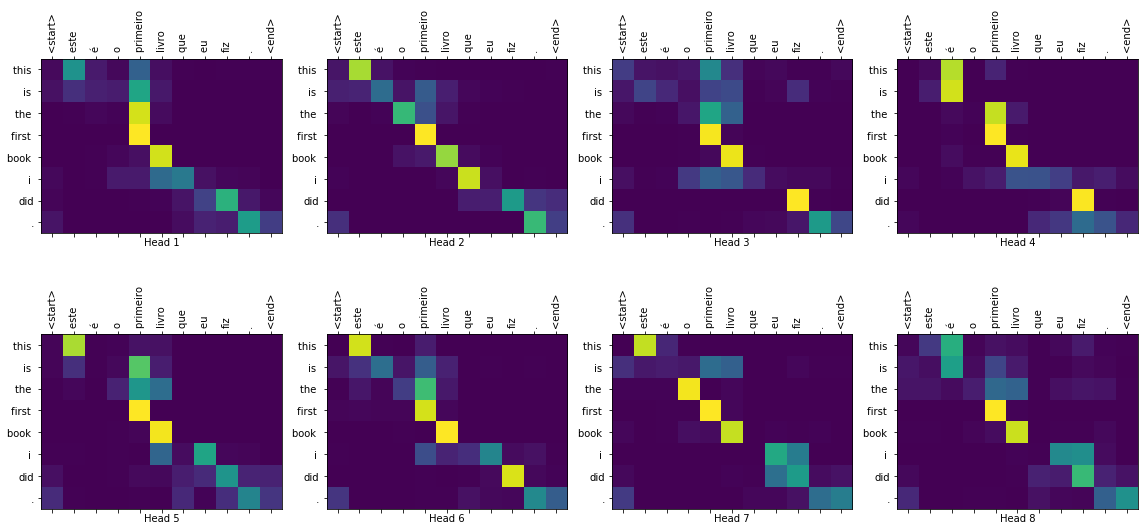

In [76]:
translate("este é o primeiro livro que eu fiz.", layer_name='decoder_layer4_att2')